# Convert Data to TF Records
The data is currently expressed as SMILES strings in a CSV file. 
We need to convert them to graph representations for easier use with TF.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from molgym.utils.conversions import convert_smiles_to_nx
from molgym.mpnn.data import make_type_lookup_tables, convert_nx_to_dict, make_tfrecord
from rdkit import Chem
import tensorflow as tf
import pandas as pd
import numpy as np
import json

## Load in the IC50 Data
Provided by Neeraj Kumar

In [2]:
data = pd.read_csv('protease_only_id_smiles_IC50.csv')

## Clean the IC50 Values
A few of our IC50 files are not floats. They are just listed as being above or below a range. For simplicity, we will assume a value of the provided threshold for each

In [3]:
data['IC50_cleaned'] = data['IC50'].apply(lambda x: float(x.strip(' ><')))

## Compute the pIC50
This has a much better distribution than IC50

In [4]:
data['pIC50'] = -1 * np.log10(data['IC50_cleaned'] * 1e-9)

Text(0, 0.5, 'Frequency')

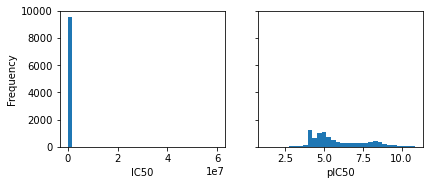

In [5]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 2.5))

axs[0].hist(data['IC50_cleaned'], bins=32)
axs[0].set_xlabel('IC50')
axs[1].hist(data['pIC50'], bins=32)
axs[1].set_xlabel('pIC50')

axs[0].set_ylabel('Frequency')

Given the huge range of values, we are going to use the log value as output for the model

## Remove Duplicates
Compute the mean of each pIC50 for all non-unique molecules to remove duplicates

In [6]:
data.rename(columns={'InChI': 'smiles'}, inplace=True)

Get the InChI keys as a unique identifier

In [7]:
data['InChIKey'] = data['smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)))

In [8]:
deduped = []
for gid, group in data.groupby('InChIKey'):
    deduped.append({
        'smiles': group['smiles'].iloc[0],
        'pIC50': group['pIC50'].mean(),
        'pIC50_std': group['pIC50'].std()
    })
print(f'Found {len(deduped)} unique molecules')

Found 6545 unique molecules


Replace the dataset with the de-duped version

In [9]:
data = pd.DataFrame(deduped)

See what the largest variances are

In [10]:
data.sort_values('pIC50_std', ascending=False).head()

,smiles,pIC50,pIC50_std
3689,CC[C@H](C)[C@H](NC(=O)[C@@H](CC(O)C[C@@H](Cc1c...,6.460409,2.916772
1596,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...,6.261439,2.772438
6348,CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C[C@@...,8.094380,2.132181
6432,OC1OCC=C2OC(=O)C=C12,6.920216,2.121320
1542,C\C=C\C\C=C\CCC(=O)[C@H]1O[C@H]1C(N)=O,4.102060,2.121320


They are not unreasonable. The largest deviations are still smaller than the mean value

## Parse the SMILES strings to NX graphs
This is our standard form for working with molecular graphs

In [11]:
data['nx'] = data['smiles'].apply(convert_smiles_to_nx)

## Convert the Objects to Dictionaries
These dictionaries will mimic the structure of the TFRecords.
We first compute a lookup table to match atom types with an integer index, 
which we will use when creating molecules

In [12]:
atom_types, bond_types = make_type_lookup_tables(data['nx'].tolist())

In [13]:
with open('atom_types.json', 'w') as fp:
    json.dump(atom_types, fp)

In [14]:
with open('bond_types.json', 'w') as fp:
    json.dump(bond_types, fp)

In [15]:
data['dict'] = data['nx'].apply(lambda x: convert_nx_to_dict(x, atom_types, bond_types))

## Save as a TF Record File
We need to add the IC50 to the record, then save it to disk

In [16]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=1)
print(f'Split off {len(test_data)} mols for testing')

Split off 655 mols for testing


In [17]:
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=2)
print(f'Split remaining mols into a {len(train_data)}/{len(val_data)} split for train and validation')

Split remaining mols into a 5301/589 split for train and validation


In [18]:
for path, data in zip(['train_data.proto', 'val_data.proto', 'test_data.proto'], 
                     [train_data, val_data, test_data]):
    with tf.io.TFRecordWriter(path) as writer:
        for _, entry in data.iterrows():
            record = entry['dict']
            record['pIC50'] = entry['pIC50']
            writer.write(make_tfrecord(record))

## Save the Cleaned Data
Because it could be useful to avoid doing this twice

In [19]:
data.drop(columns=['nx', 'dict']).to_csv('cleaned_data.csv')